In [15]:
library(limma)
library(dplyr)
library(ggplot2)
library(org.Hs.eg.db)
library(hugene10sttranscriptcluster.db)
library(readxl)
library(viridis)

Loading required package: viridisLite



In [2]:
# Cargar la matriz de expresión
expr_file <- "/home/mlopez/Desktop/alzheimer/data/GSE36980/GSE36980_series_matrix.txt.gz"
raw_data <- read.delim(gzfile(expr_file), comment.char = "!", header = TRUE, row.names = 1)

# Cargar los metadata
metadata <- read.csv("/home/mlopez/Desktop/alzheimer/results/GSE36980/GSE36980_metadata.csv", stringsAsFactors = FALSE)
rownames(metadata) <- metadata$Accession

In [3]:
# Obtener los símbolos
gene_symbols <- mapIds(hugene10sttranscriptcluster.db,
                       keys = rownames(raw_data),
                       column = "SYMBOL",
                       keytype = "PROBEID",
                       multiVals = "first")

# Añadir gene symbols como columna
raw_data$GeneSymbol <- gene_symbols[rownames(raw_data)]

# Eliminar probes sin símbolo
annotated_data <- raw_data[!is.na(raw_data$GeneSymbol), ]

# Calcular varianza por fila (sin contar la columna GeneSymbol)
annotated_data$Variance <- apply(annotated_data[, -ncol(annotated_data)], 1, var)

collapsed_data <- annotated_data %>%
  group_by(GeneSymbol) %>%
  slice_max(order_by = Variance, n = 1, with_ties = FALSE) %>%
  ungroup()

collapsed_data <- collapsed_data[!is.na(collapsed_data$GeneSymbol), ]
collapsed_data <- as.data.frame(collapsed_data[!duplicated(collapsed_data$GeneSymbol), ])

rownames(collapsed_data) <- collapsed_data$GeneSymbol
collapsed_data$GeneSymbol <- NULL
collapsed_data$Variance <- NULL

'select()' returned 1:many mapping between keys and columns



In [4]:
pdf("/home/mlopez/Desktop/alzheimer/results/GSE36980/boxplot_raw_expr_GSE36980.pdf", width=20, height=12)
# Crear boxplot
boxplot(collapsed_data,
        las = 2,               # etiquetas en el eje x verticales
        outline = FALSE,       # sin outliers para ver mejor la forma
        col = "skyblue",
        main = "Boxplot por muestra",
        ylab = "Expresión log2"  # cambia si no están log-transformados
)
dev.off()

pdf 
  2

In [5]:
# Convertir a objeto tipo `ExpressionSet` (opcional, pero útil si usas limma completo)
expr_matrix <- as.matrix(collapsed_data)
norm_expr <- normalizeBetweenArrays(expr_matrix, method = "quantile")

pdf("/home/mlopez/Desktop/alzheimer/results/GSE36980/boxplot_norm_expr_GSE36980.pdf")
boxplot(norm_expr, 
        main = "Expresión por muestra (después de normalizar)", 
        las = 2, 
        col = "lightgreen", 
        outline = FALSE)
dev.off()

pdf 
  2

In [6]:
# Calcula la varianza de cada gen (columna)
gene_variance <- apply(norm_expr, 1, var)

# Filtra genes con varianza mayor que 0.01 (ajusta el umbral si es necesario)
norm_exprs_filtered <- norm_expr[gene_variance > 0.01, ]

# Realiza PCA sobre los datos filtrados
pca_result <- prcomp(t(norm_exprs_filtered), scale. = TRUE)

# Ver la proporción de varianza explicada por cada componente principal
summary(pca_result)

# Extraer los primeros dos componentes principales
pca_data <- data.frame(PC1 = pca_result$x[, 1], PC2 = pca_result$x[, 2], Group = metadata$Title)

pdf("/home/mlopez/Desktop/alzheimer/results/GSE36980/pca_norm_expr_GSE36980.pdf")
# Graficar los primeros dos componentes principales
ggplot(pca_data, aes(x = PC1, y = PC2, color = Group)) +
  geom_point(size = 3) +
  labs(title = "PCA de Expresión Génica Normalizada", x = "Componente Principal 1", y = "Componente Principal 2") +
  theme_minimal() 
dev.off()

Importance of components:
                           PC1     PC2     PC3      PC4      PC5     PC6
Standard deviation     63.4722 53.5899 40.5704 31.79597 26.73272 25.7595
Proportion of Variance  0.2022  0.1441  0.0826  0.05073  0.03586  0.0333
Cumulative Proportion   0.2022  0.3463  0.4289  0.47960  0.51546  0.5488
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     23.59001 21.98393 21.04077 20.09339 19.47055 17.93545
Proportion of Variance  0.02792  0.02425  0.02222  0.02026  0.01902  0.01614
Cumulative Proportion   0.57669  0.60094  0.62315  0.64341  0.66244  0.67858
                           PC13     PC14     PC15     PC16     PC17     PC18
Standard deviation     17.23747 16.72694 16.08822 15.48462 14.69230 13.86166
Proportion of Variance  0.01491  0.01404  0.01299  0.01203  0.01083  0.00964
Cumulative Proportion   0.69349  0.70753  0.72052  0.73255  0.74338  0.75303
                           PC19     PC20     PC21     PC22     PC2

pdf 
  2

In [7]:
metadata$Condition <- ifelse(grepl("^AD", metadata$Title), "AD", "Control")
metadata$Region <- sub(".*_(.*)$", "\\1", metadata$Title)  # FC, TC o HI
# Crear subconjuntos por región
metadata_FC <- subset(metadata, Region == "FC")
metadata_TC <- subset(metadata, Region == "TC")
metadata_HI <- subset(metadata, Region == "HI")

# Y los datos de expresión correspondientes
expr_FC <- norm_expr[, metadata_FC$Accession]
expr_TC <- norm_expr[, metadata_TC$Accession]
expr_HI <- norm_expr[, metadata_HI$Accession]

In [8]:
#FC 

# Diseño
group_FC <- factor(metadata_FC$Condition, levels = c("Control", "AD"))
design_FC <- model.matrix(~ 0 + group_FC)
colnames(design_FC) <- levels(group_FC)

# Ajuste y contraste
fit <- lmFit(expr_FC, design_FC)
contrast <- makeContrasts(AD - Control, levels = design_FC)
fit2 <- contrasts.fit(fit, contrast)
fit2 <- eBayes(fit2)

# Resultados
res_FC <- topTable(fit2, number = Inf, adjust = "fdr")

write.csv(res_FC, file = "/home/mlopez/Desktop/alzheimer/results/GSE36980/dif_expr_results_GSE36980_FC.csv", row.names = TRUE)

In [9]:
#TC

# Diseño
group_TC <- factor(metadata_TC$Condition, levels = c("Control", "AD"))
design_TC <- model.matrix(~ 0 + group_TC)
colnames(design_TC) <- levels(group_TC)

# Ajuste y contraste
fit <- lmFit(expr_TC, design_TC)
contrast <- makeContrasts(AD - Control, levels = design_TC)
fit2 <- contrasts.fit(fit, contrast)
fit2 <- eBayes(fit2)

# Resultados
res_TC <- topTable(fit2, number = Inf, adjust = "fdr")
write.csv(res_TC, file = "/home/mlopez/Desktop/alzheimer/results/GSE36980/dif_expr_results_GSE36980_TC.csv", row.names = TRUE)

In [10]:
#HI

# Diseño
group_HI <- factor(metadata_HI$Condition, levels = c("Control", "AD"))
design_HI <- model.matrix(~ 0 + group_HI)
colnames(design_HI) <- levels(group_HI)

# Ajuste y contraste
fit <- lmFit(expr_HI, design_HI)
contrast <- makeContrasts(AD - Control, levels = design_HI)
fit2 <- contrasts.fit(fit, contrast)
fit2 <- eBayes(fit2)

# Resultados
res_HI <- topTable(fit2, number = Inf, adjust = "fdr")
write.csv(res_HI, file = "/home/mlopez/Desktop/alzheimer/results/GSE36980/dif_expr_results_GSE36980_HI.csv", row.names = TRUE)

In [11]:
# Umbral de significancia (ajustado)
padj_cutoff <- 0.05

sig_FC <- rownames(res_FC[res_FC$adj.P.Val < padj_cutoff, ])
sig_TC <- rownames(res_TC[res_TC$adj.P.Val < padj_cutoff, ])
sig_HI <- rownames(res_HI[res_HI$adj.P.Val < padj_cutoff, ])

In [12]:
# Lista de todos los genes únicos
all_genes <- unique(c(sig_FC, sig_TC, sig_HI))

# Crear matriz lógica
venn_input <- data.frame(
  FC = all_genes %in% sig_FC,
  TC = all_genes %in% sig_TC,
  HI = all_genes %in% sig_HI
)
rownames(venn_input) <- all_genes

# Crear objeto Venn
venn_counts <- vennCounts(venn_input)

pdf("/home/mlopez/Desktop/alzheimer/results/GSE36980/venn_diagr_compar_result_muestr_GSE36980.pdf")
vennDiagram(venn_counts, circle.col = c("red", "green", "blue"))
dev.off()

pdf 
  2

In [16]:
AD_T4_targets <- read_excel("/home/mlopez/Desktop/alzheimer/data/AD_T4_targets.xlsx")

New names:
• `` -> `...1`


In [24]:
T4_expdf_FC <- na.omit(res_FC[AD_T4_targets$Prot,])
T4_expdf_TC <- na.omit(res_TC[AD_T4_targets$Prot,])
T4_expdf_HI <- na.omit(res_HI[AD_T4_targets$Prot,])

In [27]:
table(T4_expdf_FC$adj.P.Val < 0.05)
table(T4_expdf_TC$adj.P.Val < 0.05)
table(T4_expdf_HI$adj.P.Val < 0.05)


FALSE 
   11 


FALSE  TRUE 
   10     1 


FALSE 
   11 

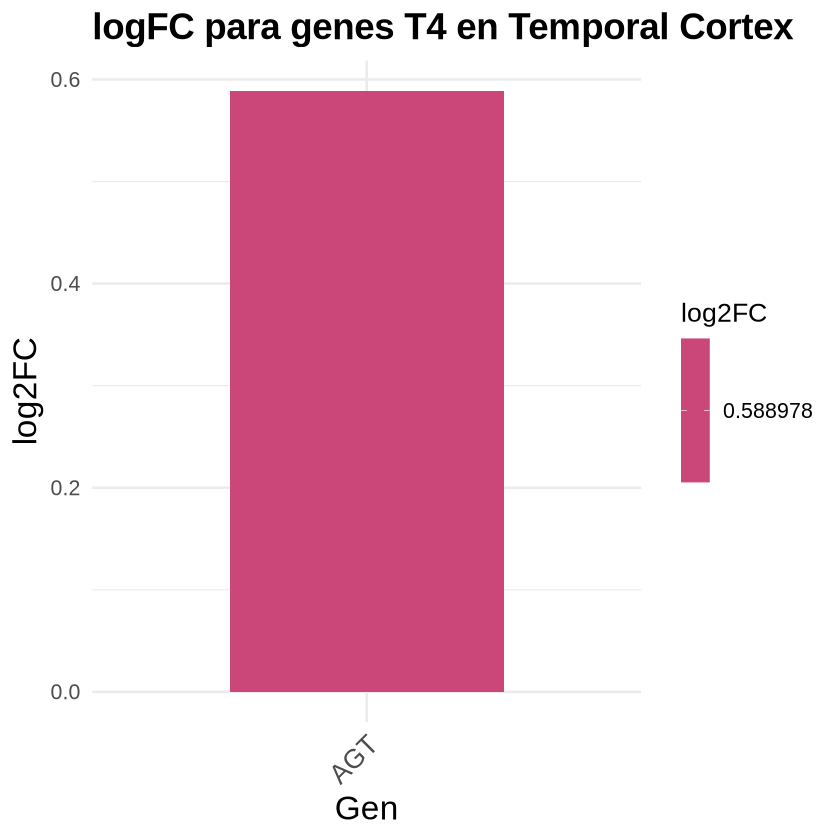

In [31]:
T4_expdf_TC_sig <- T4_expdf_TC[T4_expdf_TC$adj.P.Val < 0.05, ]

T4_expdf_TC_sig$gene <- rownames(T4_expdf_TC_sig)

ggplot(T4_expdf_TC_sig, aes(x = gene, y = logFC, fill = logFC)) +
  geom_col(width = 0.6) +
  scale_fill_viridis(option = "C", direction = -1) +
  labs(
    title = "logFC para genes T4 en Temporal Cortex",
    x = "Gen",
    y = "log2FC",
    fill = "log2FC"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
    axis.title = element_text(size = 20),
    plot.title = element_text(size = 22, face = "bold")
  )